# Geomagnetic Model Residuals

> Abstract: An exploration of geomagnetic data-model residuals evaluated through VirES (along Swarm orbits).

In [1]:
%load_ext watermark
%watermark -i -v -p viresclient,pandas,xarray,matplotlib

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.18.0

viresclient: 0.12.0
pandas     : 2.1.3
xarray     : 2023.12.0
matplotlib : 3.8.2



In [2]:
from viresclient import SwarmRequest
import matplotlib.pyplot as plt

## One day of residuals

(data minus a core field model)

In [3]:
request = SwarmRequest()
request.set_collection("SW_OPER_MAGA_LR_1B")
request.set_products(
    measurements=["B_NEC"],
    models=["CHAOS-Core"],
    residuals=True,
    sampling_step="PT5S",
    auxiliaries=["MLT", "QDLat", "SunZenithAngle"]
)
data = request.get_between(
    "2019-01-01", "2019-01-02",
    asynchronous=False, show_progress=False
)
ds = data.as_xarray()
ds

<xarray.Dataset>
Dimensions:               (Timestamp: 17280, NEC: 3)
Coordinates:
  * Timestamp             (Timestamp) datetime64[ns] 2019-01-01 ... 2019-01-0...
  * NEC                   (NEC) <U1 'N' 'E' 'C'
Data variables:
    Spacecraft            (Timestamp) object 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    MLT                   (Timestamp) float64 14.8 14.79 14.79 ... 2.419 2.419
    SunZenithAngle        (Timestamp) float64 40.87 40.97 41.08 ... 141.0 141.1
    QDLat                 (Timestamp) float64 -13.95 -13.63 ... 40.36 40.02
    Radius                (Timestamp) float64 6.819e+06 6.819e+06 ... 6.809e+06
    B_NEC_res_CHAOS-Core  (Timestamp, NEC) float64 -12.9 -19.08 ... 5.822 7.033
    Longitude             (Timestamp) float64 -136.0 -136.0 ... 40.87 40.88
    Latitude              (Timestamp) float64 -17.03 -16.71 ... 44.51 44.19
Attributes:
    Sources:         ['SW_OPER_MAGA_LR_1B_20190101T000000_20190101T235959_060...
    MagneticModels:  ["CHAOS-Core = 'CHAOS-Core'(max_degree=20,min_degree=1)"]
    AppliedFilters:  []

xarray provides some convenient direct plotting tools through integration with matplotlib:

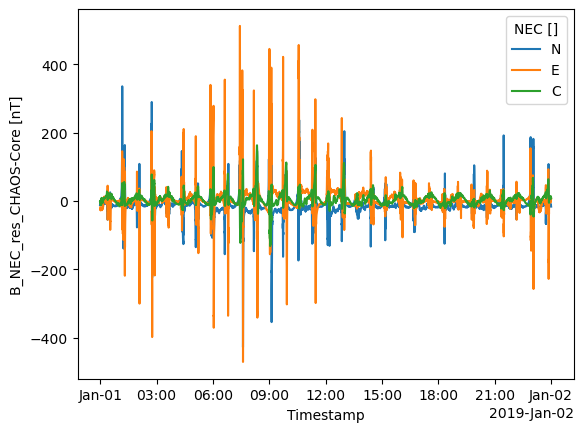

In [4]:
ds["B_NEC_res_CHAOS-Core"].plot.line(x="Timestamp");

This allows some very compact plotting commands to create complex figures, if you know how! This kind of plotting takes a while to learn and experiment with to get right, but results in short and manageable code.

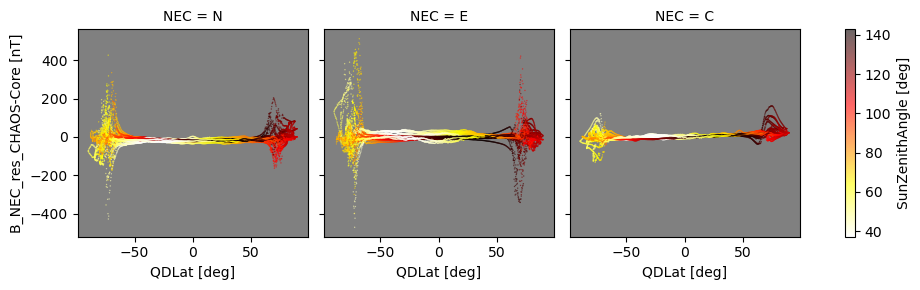

In [5]:
facetgrid = ds.plot.scatter(x="QDLat", y="B_NEC_res_CHAOS-Core", col="NEC",
                s=1, hue="SunZenithAngle", cmap="hot_r", alpha=0.6, linewidths=0)
for ax in facetgrid.axs.flat:
    ax.set_facecolor("grey")

(showing that we are in daylight more in the Southern hemisphere, while in darkness in the Northern, because the data is from January - Northern winter)

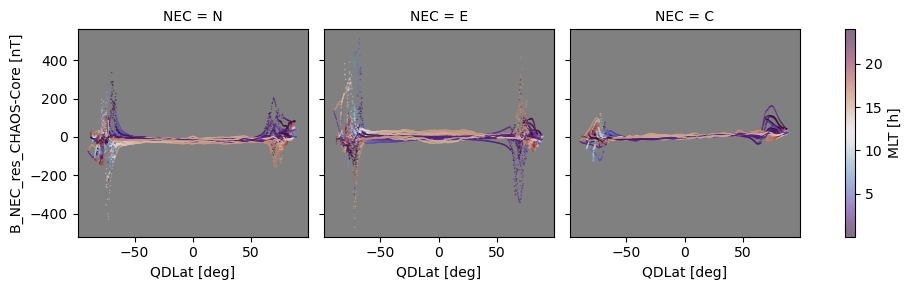

In [6]:
facetgrid = ds.plot.scatter(x="QDLat", y="B_NEC_res_CHAOS-Core", col="NEC",
                s=1, hue="MLT", cmap="twilight_shifted", alpha=0.6, linewidths=0)
for ax in facetgrid.axs.flat:
    ax.set_facecolor("grey")

(showing the rapid movement through local time sectors (MLT) when the satellite passes through polar regions)

The above figures show large residuals in the polar regions due to currents in the auroral oval. These cause greater disturbance in the Northward (N) and Eastward (E) components of the magnetic field because of the geometry of the field-aligned currents (FACs) which cause the magnetic disturbance.

## Access 1 year of data and models

Let's inspect a whole year of data (at 2-minute sampling):

- The `B_NEC` vector from Swarm Alpha
- All parts of the CHAOS model (core, crust, magnetosphere) evaluated at the same points
- MLT, QDLat, and SunZenithAngle which are also evaluated on-the-fly
- Filtered to remove some bad data (according to `Flags_F`) and restricted to geomagnetically quiet data (according to `Kp`)

We fetch the model values themselves as well as the measurements (instead of just the residuals as above) so that we can manipulate all the different components locally.

**Warning**: This will take several minutes to process

In [7]:
request = SwarmRequest()
request.set_collection("SW_OPER_MAGA_LR_1B")
request.set_products(
    measurements=["B_NEC"],
    models=["CHAOS-Core", "CHAOS-Static", "CHAOS-MMA-Primary", "CHAOS-MMA-Secondary"],
    auxiliaries=["MLT", "QDLat", "SunZenithAngle", "OrbitNumber"],
    sampling_step="PT120S"
)
request.set_range_filter("Flags_F", 0, 1)
request.set_range_filter("Kp", 0, 3)
# request.set_range_filter("SunZenithAngle", 100, 180)
data = request.get_between("2019-01-01", "2020-01-01")
ds = data.as_xarray()
# Remove the extra-long Sources list
ds.attrs["Sources"] = "Many"
ds

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (44.068MB)

<xarray.Dataset>
Dimensions:                    (Timestamp: 242598, NEC: 3)
Coordinates:
  * Timestamp                  (Timestamp) datetime64[ns] 2019-01-01 ... 2019...
  * NEC                        (NEC) <U1 'N' 'E' 'C'
Data variables: (12/13)
    Spacecraft                 (Timestamp) object 'A' 'A' 'A' ... 'A' 'A' 'A'
    B_NEC                      (Timestamp, NEC) float64 2.368e+04 ... 4.915e+04
    MLT                        (Timestamp) float64 14.8 14.72 ... 6.219 6.348
    OrbitNumber                (Timestamp) int32 28692 28692 ... 34324 34324
    SunZenithAngle             (Timestamp) float64 40.87 43.82 ... 107.4 108.7
    B_NEC_CHAOS-Core           (Timestamp, NEC) float64 2.369e+04 ... 4.915e+04
    ...                         ...
    Radius                     (Timestamp) float64 6.819e+06 ... 6.803e+06
    Longitude                  (Timestamp) float64 -136.0 -136.1 ... 97.65 99.22
    B_NEC_CHAOS-Static         (Timestamp, NEC) float64 -0.1243 1.575 ... 0.5559
    Latitude                   (Timestamp) float64 -17.03 -9.329 ... 61.38 69.06
    B_NEC_CHAOS-MMA-Secondary  (Timestamp, NEC) float64 -0.303 0.9856 ... 1.384
    B_NEC_CHAOS-MMA-Primary    (Timestamp, NEC) float64 -13.85 1.0 ... 5.657
Attributes:
    Sources:         Many
    MagneticModels:  ["CHAOS-Core = 'CHAOS-Core'(max_degree=20,min_degree=1)"...
    AppliedFilters:  ['Flags_F <= 1', 'Flags_F >= 0', 'Kp <= 3', 'Kp >= 0']

We can construct `xarray.DataArray`'s based on `ds`:

In [8]:
ds["B_NEC"]

<xarray.DataArray 'B_NEC' (Timestamp: 242598, NEC: 3)>
array([[ 2.36759552e+04,  5.29527560e+03, -1.22484488e+04],
       [ 2.45740707e+04,  4.69855800e+03, -5.59756670e+03],
       [ 2.48499010e+04,  4.26007020e+03,  1.28627330e+03],
       ...,
       [ 1.40707746e+04, -4.06713000e+01,  4.66820192e+04],
       [ 9.73485700e+03,  1.19815900e+02,  4.86510752e+04],
       [ 6.01312440e+03,  2.77378700e+02,  4.91516574e+04]])
Coordinates:
  * Timestamp  (Timestamp) datetime64[ns] 2019-01-01 ... 2019-12-31T23:58:00
  * NEC        (NEC) <U1 'N' 'E' 'C'
Attributes:
    units:        nT
    description:  Magnetic field vector, NEC frame

In [9]:
ds["B_NEC"] - ds["B_NEC_CHAOS-Core"]

<xarray.DataArray (Timestamp: 242598, NEC: 3)>
array([[-12.90431938, -19.0818653 ,  -1.32983847],
       [-10.09148235, -24.70662095, -11.12612882],
       [  1.42928765, -22.22792618,   3.14060466],
       ...,
       [ -4.72726965,   1.16761064,   6.10664818],
       [ -2.61528172,  -0.85032395,   8.46239155],
       [  0.43268334,   5.14034461,   6.43296944]])
Coordinates:
  * Timestamp  (Timestamp) datetime64[ns] 2019-01-01 ... 2019-12-31T23:58:00
  * NEC        (NEC) <U1 'N' 'E' 'C'

... and we can plot these directly:

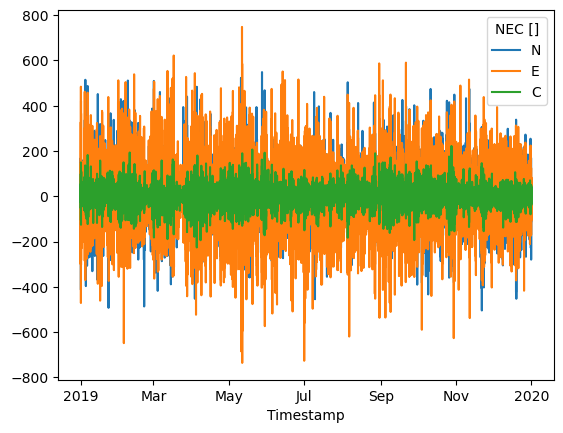

In [10]:
(ds["B_NEC"] - ds["B_NEC_CHAOS-Core"]).plot.line(x="Timestamp");

We can slice out a particular time window:

In [11]:
# Selects two days
ds.sel({"Timestamp": slice("2019-01-01", "2019-01-02")})

<xarray.Dataset>
Dimensions:                    (Timestamp: 1415, NEC: 3)
Coordinates:
  * Timestamp                  (Timestamp) datetime64[ns] 2019-01-01 ... 2019...
  * NEC                        (NEC) <U1 'N' 'E' 'C'
Data variables: (12/13)
    Spacecraft                 (Timestamp) object 'A' 'A' 'A' ... 'A' 'A' 'A'
    B_NEC                      (Timestamp, NEC) float64 2.368e+04 ... -4.556e+04
    MLT                        (Timestamp) float64 14.8 14.72 ... 18.85 17.34
    OrbitNumber                (Timestamp) int32 28692 28692 ... 28723 28723
    SunZenithAngle             (Timestamp) float64 40.87 43.82 ... 62.83 57.18
    B_NEC_CHAOS-Core           (Timestamp, NEC) float64 2.369e+04 ... -4.555e+04
    ...                         ...
    Radius                     (Timestamp) float64 6.819e+06 ... 6.823e+06
    Longitude                  (Timestamp) float64 -136.0 -136.1 ... -150.7
    B_NEC_CHAOS-Static         (Timestamp, NEC) float64 -0.1243 ... -0.1479
    Latitude                   (Timestamp) float64 -17.03 -9.329 ... -78.6
    B_NEC_CHAOS-MMA-Secondary  (Timestamp, NEC) float64 -0.303 ... 0.03659
    B_NEC_CHAOS-MMA-Primary    (Timestamp, NEC) float64 -13.85 1.0 ... -12.97
Attributes:
    Sources:         Many
    MagneticModels:  ["CHAOS-Core = 'CHAOS-Core'(max_degree=20,min_degree=1)"...
    AppliedFilters:  ['Flags_F <= 1', 'Flags_F >= 0', 'Kp <= 3', 'Kp >= 0']

... and subselect according to parts of the data:

In [12]:
ds.where(ds["SunZenithAngle"] > 100, drop=True)

<xarray.Dataset>
Dimensions:                    (Timestamp: 93945, NEC: 3)
Coordinates:
  * Timestamp                  (Timestamp) datetime64[ns] 2019-01-01T00:24:00...
  * NEC                        (NEC) <U1 'N' 'E' 'C'
Data variables: (12/13)
    Spacecraft                 (Timestamp) object 'A' 'A' 'A' ... 'A' 'A' 'A'
    B_NEC                      (Timestamp, NEC) float64 3.741e+03 ... 4.915e+04
    MLT                        (Timestamp) float64 13.4 11.8 ... 6.219 6.348
    OrbitNumber                (Timestamp) float64 2.869e+04 ... 3.432e+04
    SunZenithAngle             (Timestamp) float64 104.1 109.9 ... 107.4 108.7
    B_NEC_CHAOS-Core           (Timestamp, NEC) float64 3.737e+03 ... 4.915e+04
    ...                         ...
    Radius                     (Timestamp) float64 6.805e+06 ... 6.803e+06
    Longitude                  (Timestamp) float64 -131.0 -120.0 ... 97.65 99.22
    B_NEC_CHAOS-Static         (Timestamp, NEC) float64 -0.8225 ... 0.5559
    Latitude                   (Timestamp) float64 75.39 82.85 ... 61.38 69.06
    B_NEC_CHAOS-MMA-Secondary  (Timestamp, NEC) float64 1.187 0.2541 ... 1.384
    B_NEC_CHAOS-MMA-Primary    (Timestamp, NEC) float64 0.3957 -0.8031 ... 5.657
Attributes:
    Sources:         Many
    MagneticModels:  ["CHAOS-Core = 'CHAOS-Core'(max_degree=20,min_degree=1)"...
    AppliedFilters:  ['Flags_F <= 1', 'Flags_F >= 0', 'Kp <= 3', 'Kp >= 0']

We can use the above to construct a plot based on part of the data

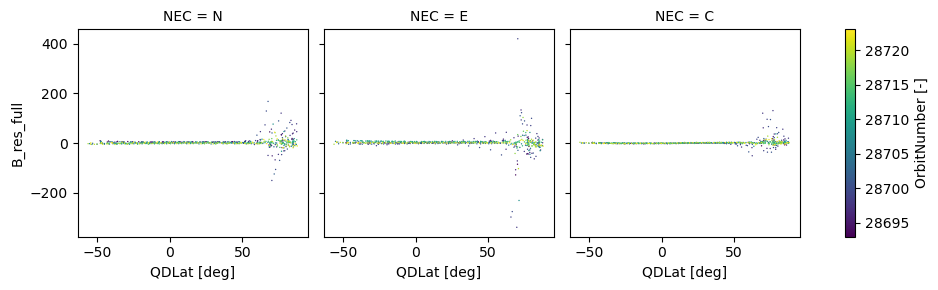

In [13]:
# Select one day
_ds = ds.sel({"Timestamp": slice("2019-01-01", "2019-01-02")})
# Select nightside data from it
_ds_dark = _ds.where(_ds["SunZenithAngle"] > 100, drop=True)
# Append a custom residual of B-MCO-MLI-MMA
_ds_dark["B_res_full"] = _ds_dark["B_NEC"] - _ds_dark["B_NEC_CHAOS-Core"] \
                                           - _ds_dark["B_NEC_CHAOS-Static"] \
                                           - _ds_dark["B_NEC_CHAOS-MMA-Primary"] \
                                           - _ds_dark["B_NEC_CHAOS-MMA-Secondary"]
_ds_dark.plot.scatter(x="QDLat", y="B_res_full", hue="OrbitNumber", col="NEC",
                      cmap="viridis", s=1, linewidths=0);

## Residuals to model combinations (one month)

First we adjust the `Dataset` so that it contains the custom residuals themselves. We store them as both regular `data variables` and as a higher dimensional `"B_residuals"` which includes all of them. This is inefficient but is convenient for the plotting tools used below.

In [14]:
def assign_residuals(ds):
    # Work on a copy of the Dataset so we don't disturb the original
    ds = ds.copy()
    # Assign custom residual variables
    ds["B-MCO"] = ds["B_NEC"] - ds["B_NEC_CHAOS-Core"]
    ds["B-MCO-MLI"] = ds["B-MCO"] - ds["B_NEC_CHAOS-Static"]
    ds["B-MCO-MLI-MMA"] = ds["B-MCO-MLI"] - ds["B_NEC_CHAOS-MMA-Primary"]\
                                          - ds["B_NEC_CHAOS-MMA-Secondary"]
    # Create a new DataArray to contain all these residual combinations
    da = ds["B_NEC"].copy()
    da.name = "B_residuals"
    # Expand to 3 dimensions for each residual combination to use
    da = da.expand_dims({"residuals": 3})
    da.coords["residuals"] = ["B-MCO", "B-MCO-MLI", "B-MCO-MLI-MMA"]
    # Assign the residual data to the DataArray
    da = da.copy()
    da.loc[{"residuals": "B-MCO"}] = ds["B-MCO"]
    da.loc[{"residuals": "B-MCO-MLI"}] = ds["B-MCO-MLI"]
    da.loc[{"residuals": "B-MCO-MLI-MMA"}] = ds["B-MCO-MLI-MMA"]
    # Assign the new DataArray to the original Dataset
    ds["B_residuals"] = da
    return ds

ds = assign_residuals(ds)
ds

<xarray.Dataset>
Dimensions:                    (Timestamp: 242598, NEC: 3, residuals: 3)
Coordinates:
  * Timestamp                  (Timestamp) datetime64[ns] 2019-01-01 ... 2019...
  * NEC                        (NEC) <U1 'N' 'E' 'C'
  * residuals                  (residuals) <U13 'B-MCO' ... 'B-MCO-MLI-MMA'
Data variables: (12/17)
    Spacecraft                 (Timestamp) object 'A' 'A' 'A' ... 'A' 'A' 'A'
    B_NEC                      (Timestamp, NEC) float64 2.368e+04 ... 4.915e+04
    MLT                        (Timestamp) float64 14.8 14.72 ... 6.219 6.348
    OrbitNumber                (Timestamp) int32 28692 28692 ... 34324 34324
    SunZenithAngle             (Timestamp) float64 40.87 43.82 ... 107.4 108.7
    B_NEC_CHAOS-Core           (Timestamp, NEC) float64 2.369e+04 ... 4.915e+04
    ...                         ...
    B_NEC_CHAOS-MMA-Secondary  (Timestamp, NEC) float64 -0.303 0.9856 ... 1.384
    B_NEC_CHAOS-MMA-Primary    (Timestamp, NEC) float64 -13.85 1.0 ... 5.657
    B-MCO                      (Timestamp, NEC) float64 -12.9 -19.08 ... 6.433
    B-MCO-MLI                  (Timestamp, NEC) float64 -12.78 -20.66 ... 5.877
    B-MCO-MLI-MMA              (Timestamp, NEC) float64 1.376 -22.64 ... -1.164
    B_residuals                (residuals, Timestamp, NEC) float64 -12.9 ... ...
Attributes:
    Sources:         Many
    MagneticModels:  ["CHAOS-Core = 'CHAOS-Core'(max_degree=20,min_degree=1)"...
    AppliedFilters:  ['Flags_F <= 1', 'Flags_F >= 0', 'Kp <= 3', 'Kp >= 0']

Here we create scatter plots to show the data in different views. We select only the first month - this reduces the crowding on the figures but shows that we should seek different methods to produce summary views of the data for longer time periods. 

/tmp/ipykernel_2563/2614893674.py:6: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in facetgrid.axes.flat:


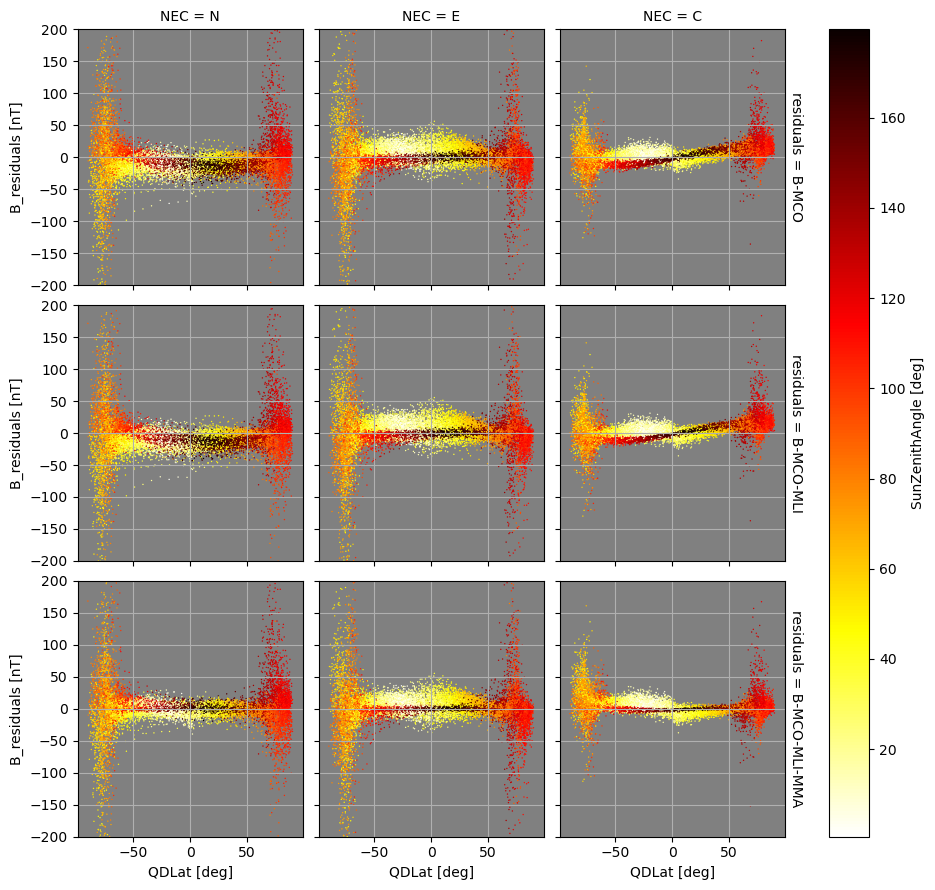

In [15]:
facetgrid = (
    ds.sel({"Timestamp": slice("2019-01-01", "2019-02-01")})
      .plot.scatter(x="QDLat", y="B_residuals", col="NEC", row="residuals",
                    sharex="all", sharey="row", s=1, linewidths=0,
                    hue="SunZenithAngle", cmap="hot_r"))
for ax in facetgrid.axes.flat:
    ax.set_facecolor("grey")
    ax.grid()
    ax.set_ylim((-200, 200))

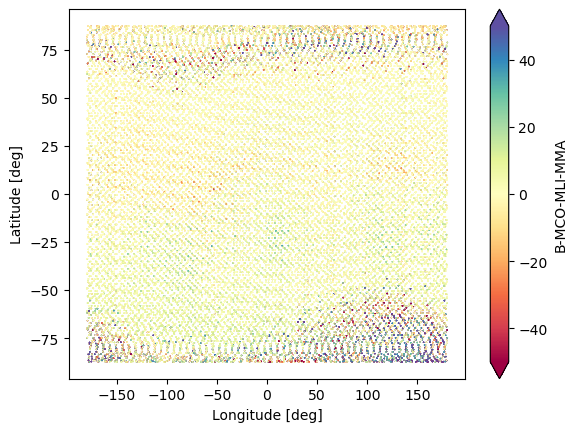

In [16]:
(
    ds
    .sel({"Timestamp": slice("2019-01-01", "2019-02-01")})
    .plot.scatter(x="Longitude", y="Latitude", hue="B-MCO-MLI-MMA",
                  s=1, linewidths=0, cmap="Spectral", vmin=-50, vmax=50)
);

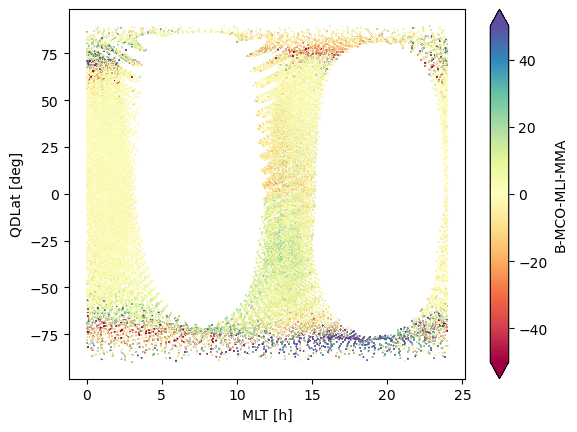

In [17]:
(
    ds
    .sel({"Timestamp": slice("2019-01-01", "2019-02-01")})
    .plot.scatter(x="MLT", y="QDLat", hue="B-MCO-MLI-MMA",
                  s=1, linewidths=0, cmap="Spectral", vmin=-50, vmax=50)
);

## Statistical summaries of data over the full year

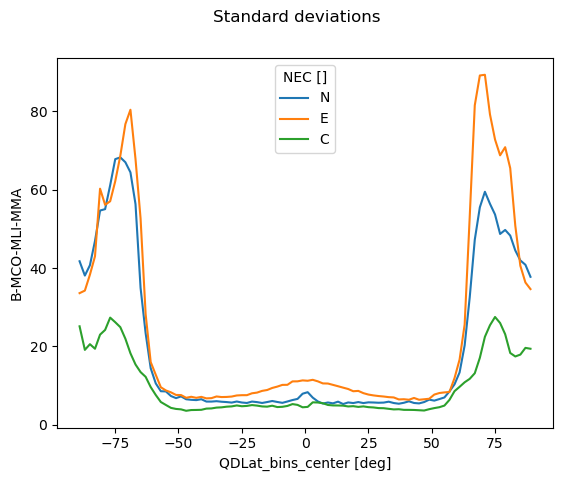

In [18]:
(
    ds
       .groupby_bins("QDLat", 90)
       .std()["B-MCO-MLI-MMA"]
       .plot.line(x="QDLat_bins")
)
plt.suptitle("Standard deviations");

This shows the large variability in the data over the polar regions